In [1]:
import skeliner as sk
import matplotlib.pyplot as plt

In [2]:
MESH_PATH = "../data/720575940545220339.obj"
mesh = sk.io.load_mesh(MESH_PATH)

In [3]:
skel = sk.skeletonize(mesh, 
    detect_soma=True,     
    # --- post-processing parameters ---
    collapse_soma=True, 
    bridge_gaps=True, 
    prune_tiny_neurites=True, 
    verbose=True,
)

[skeliner] starting skeletonisation (636684 vertices, 1274227 faces)
 ↳  build surface graph                          … 3.20 s
 ↳  bin surface vertices by geodesic distance    … 2.63 s
 ↳  compute bin centroids and radii              … 5.02 s
 ↳  post-skeletonization soma detection          … 0.09 s
      └─ Found soma at [952297.3, 1086526.5, 34228.2] (r = 8494.36)
 ↳  map mesh faces to skeleton edges             … 0.54 s
 ↳  merge redundant near-soma nodes              … 0.19 s
      └─ 179 nodes merged into soma
      └─ Moved Soma to [951784.4, 1086614.1, 34064.4] (r = 10707.70)
 ↳  bridge skeleton gaps                         … 0.18 s
 ↳  build global minimum-spanning tree           … 0.10 s
 ↳  prune tiny neurites                          … 0.14 s
TOTAL (soma + core + post)                       … 12.10 s (0.09 + 11.22 + 0.79)
(12,377 nodes, 12,376 edges)


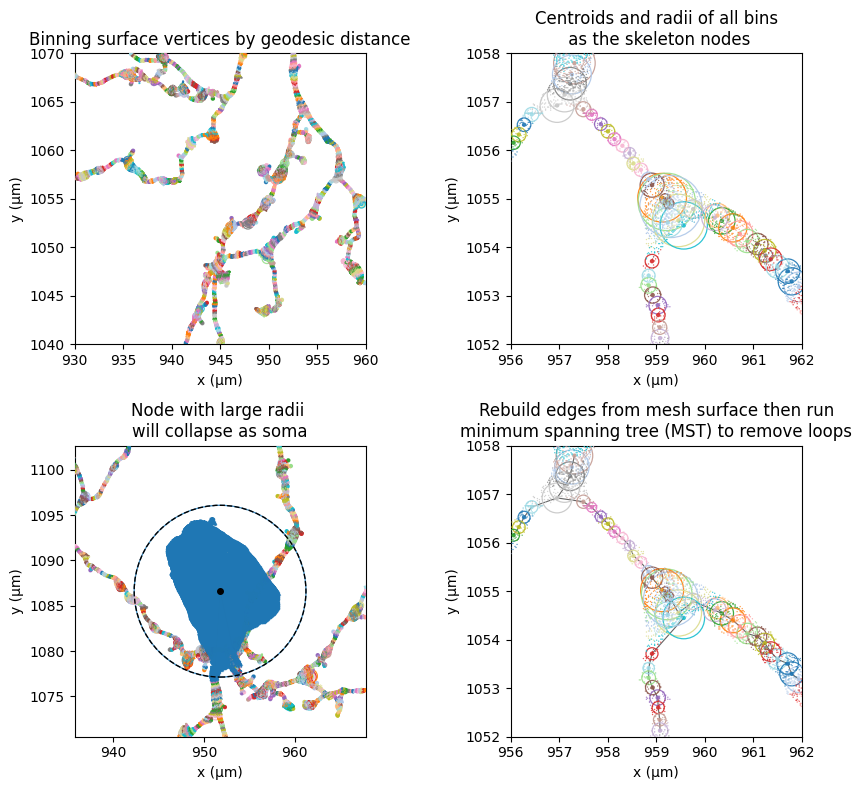

In [4]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig, ax = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    figsize=(10, 8),
)

_ = sk.plot.diagnostic(
    mesh, skel,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=True, show_node_ids=False,
    xlim=(0.93e3, 0.96e3), 
    ylim=(1.04e3, 1.07e3),
    scale=1e-3, unit="µm",
    ax=ax["A"], title="Binning surface vertices by geodesic distance"
)   


_ = sk.plot.diagnostic(
    mesh, skel,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=False, show_node_ids=False,
    xlim=(0.956e3, 0.962e3), 
    ylim=(1.052e3, 1.058e3),
    scale=1e-3, unit="µm",
    ax=ax["B"], title="Centroids and radii of all bins\n as the skeleton nodes"
)

soma_xy = skel.nodes[0][:2] * 1e-3
soma_r = skel.r[0] * 1e-3 * 1.5
_ = sk.plot.diagnostic(
    mesh, skel,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=True, show_node_ids=False,
    xlim=(soma_xy[0] - soma_r, soma_xy[0] + soma_r),
    ylim=(soma_xy[1] - soma_r, soma_xy[1] + soma_r),
    scale=1e-3, unit="µm",
    ax=ax["C"], title="Node with large radii \nwill collapse as soma"
)

_ = sk.plot.diagnostic(
    mesh, skel,
    plane="xy", bins=300,
    draw_nodes=True,
    draw_edges=True, show_node_ids=False,
    xlim=(0.956e3, 0.962e3), 
    ylim=(1.052e3, 1.058e3),
    scale=1e-3, unit="µm",
    ax=ax["D"], title="Rebuild edges from mesh surface then run\nminimum spanning tree (MST) to remove loops"
)


In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-24 13:21:26CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

matplotlib: 3.10.3
skeliner  : 0.1.0

Watermark: 2.5.0

